# Sprawozdanie - MOwNiT - laboratorium 9., zadanie 2.

#### Autor: Jakub Psarski

## Optical Character Recognition

Napisz program przekształacający obraz w tekst, przyjmując następujące założenia:
1. Na obrazie znajduje się tekst złożony z małych liter alfabetu łacińskiego oraz cyfr
2. Na obrazie występuje jeden typ i rozmiar czcionki
3. Weź pod uwagę czcionki szeryfowe i bezszeryfowe
4. W tekście występują znaki przestankowe: .,?!
5. Tekst składa się z wielu linii
6. Tekst może być obrócony (krzywo zeskanowany w całości)
7. Program powinien zwracać tekst wraz ze znakami białymi i znakami nowych linii
8. Program może raportować procent poprawnie rozpoznanych liter dla pre-definiowanych
obrazów testowych
9. Program powinien dodatkowo zliczać liczbę wystąpień każdej litery
10. Należy zastosować operację splotu i DFT albo inne metody (klasyfikacja)
11. Należy dokonać redukcji szumu na obrazie wejściowym

### Importowanie potrzebnych bibliotek oraz funkcji pomocniczych

In [1]:
import os
from collections import defaultdict
from difflib import SequenceMatcher

import pandas as pd
from ocr.util import (CHARACTERS, IMG_DIR, correct_image_rotation, create_text_image, denoise_image, load_font, load_image, read_text)
from PIL import ImageOps

### 1. Główna funkcja - `ocr`

Główna funkcja OCR, która przetwarza obraz i zwraca rozpoznany tekst wraz z liczbą wystąpień każdego znaku. Funkcja przeprowadza pełny proces przetwarzania: odszumianie, korekcję rotacji, inwersję kolorów, rozpoznawanie znaków, grupowanie ich w linie i rekonstrukcję słów z odpowiednimi spacjami. Na końcu zwraca rozpoznany tekst oraz statystyki wystąpień poszczególnych znaków.

In [2]:
def ocr(image, font_name, font_size, confidence_threshold):
    """Main OCR function that processes an image and returns recognized text."""
    denoised_image = denoise_image(image)
    rotated_image = correct_image_rotation(denoised_image)
    inverted_image = ImageOps.invert(rotated_image)
    cropped_image = inverted_image.crop(inverted_image.getbbox())

    char_positions = read_text(
        cropped_image, font_name, font_size, confidence_threshold
    )

    line_groups = defaultdict(list)
    line_height = create_text_image("a", font_name, font_size).height

    for y_pos, x_pos, character in char_positions:
        matching_line = None
        for existing_line_y in line_groups.keys():
            if abs(y_pos - existing_line_y) < line_height:
                matching_line = existing_line_y
                break

        if matching_line is not None:
            line_groups[matching_line].append((x_pos, character))
        else:
            line_groups[y_pos] = [(x_pos, character)]

    text_lines = [char_list for _, char_list in sorted(line_groups.items())]

    reconstructed_text = ""
    space_width_threshold = load_font(font_name, font_size).getlength(" ") * 0.7

    for line_chars in text_lines:
        if not line_chars:
            continue

        sorted_line = sorted(line_chars)
        previous_x_position = sorted_line[0][0]

        for char_index, (x_position, character) in enumerate(sorted_line):
            if char_index > 0:
                char_width = create_text_image(character, font_name, font_size).width
                gap_size = x_position - previous_x_position - char_width
                if gap_size > space_width_threshold:
                    reconstructed_text += " "

            reconstructed_text += character
            previous_x_position = x_position

        reconstructed_text += "\n"

    char_counter = {c: reconstructed_text.count(c) for c in CHARACTERS}
    return reconstructed_text, char_counter

### 2. Funkcje pomocnicze

- `denoise_image` - Stosuje filtr odszumiający w celu poprawy jakości obrazu. Używa algorytmu fastNlMeansDenoising z biblioteki OpenCV do redukcji szumu.

- `correct_image_rotation` - Automatycznie koryguje obrót tekstu w obrazie używając analizy minimalnego prostokąta opisującego tekst. Funkcja wykorzystuje OpenCV do znajdowania optymalnego kąta korekcji.

- `read_text` - Wyodrębnia pozycje tekstu z obrazu używając dopasowania wzorców i korelacji. Funkcja przechodzi przez znaki w określonej kolejności i znajduje ich lokalizacje w obrazie z zadanym poziomem pewności.

- `combine_image_with_pattern` - Łączy obraz bazowy z wzorcem tekstowym do analizy korelacji. Funkcja tworzy nowy obraz zawierający oryginalny obraz i wzorzec umieszczony poniżej.

- `cross_correlation` - Wykonuje korelację wzajemną między obrazem a wzorcem używając szybkiej transformaty Fouriera. Funkcja zwraca macierz korelacji wskazującą podobieństwa między obrazami.

- `correlation_matrix` - Buduje macierz korelacji między wszystkimi parami znaków dla danej czcionki i rozmiaru. Macierz zawiera współczynniki podobieństwa używane do określenia kolejności rozpoznawania znaków.

- `recognition_order` - Określa optymalną kolejność rozpoznawania znaków na podstawie ich unikalności i podobieństwa. Funkcja grupuje znaki według liczby pików korelacji i sortuje je według macierzy korelacji.

- `load_image`, `load_font` - Wczytują z plików obraz do przetworzenia oraz czcionkę.

- `create_text_image` - Generuje obraz zawierający określony tekst z opcjonalnymi transformacjami jak szum, obrót czy inwersja kolorów. Funkcja automatycznie dopasowuje rozmiar obrazu do tekstu i zapisuje wynik do pliku.

### 3. Funkcja do wizualizacji wyników

In [3]:
def display_results(results):
    """Display OCR test results in a formatted table."""
    df = pd.DataFrame(results)

    print("\nSUMMARY")
    print("=" * 60)

    print("\nAverage accuracy by font:")
    font_avg = df.groupby("font")["accuracy"].mean().reset_index()
    font_avg["accuracy"] = font_avg["accuracy"].round(2)
    display(font_avg)

    print("\nAverage accuracy by confidence level:")
    conf_avg = df.groupby("confidence")["accuracy"].mean().reset_index()
    conf_avg["accuracy"] = conf_avg["accuracy"].round(2)
    display(conf_avg)

    print("\nNoise test results (accuracy %):")
    noise_pivot = (
        df[df["test_type"] == "noise"]
        .pivot_table(
            values="accuracy",
            index=["font", "noise_level"],
            columns="confidence",
            aggfunc="mean",
        )
        .round(2)
    )
    display(noise_pivot)

    print("\nRotation test results (accuracy %):")
    rotation_pivot = (
        df[df["test_type"] == "rotation"]
        .pivot_table(
            values="accuracy",
            index=["font", "rotation_angle"],
            columns="confidence",
            aggfunc="mean",
        )
        .round(2)
    )
    display(rotation_pivot)

### 4. Wyniki


NOISE TEST - arial

Font: arial, noise: 0



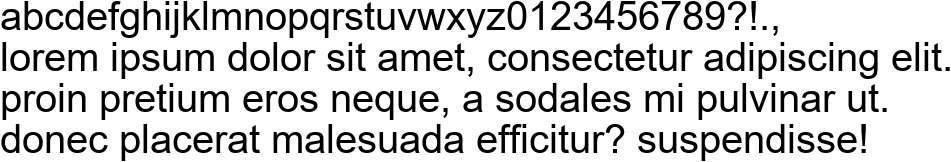

Input text:
abcdefghijklmnopqrstuvwxyz0123456789?!.,
lorem ipsum dolor sit amet, consectetur adipiscing elit.
proin pretium eros neque, a sodales mi pulvinar ut. 
donec placerat malesuada efficitur? suspendisse!

Detected text:

j pq y iiiiiiiiiiiiiiii
aaabbbcdddeeefghhhllllljjjkkk!!mmmnnnopppqqqrssstttuuuvvvwwwxyyyzzz0001112344456789?!!!.iiiiiiiiiiiiiii
!!orreeemmm lllllpppsssuuummm dddo!orrr ssslllllt aaammmeeetttiiiiiiiiiiiii connnssseeecteeetttuuurrr aaadddlllllppplllllsssclllllnnng eee!!lllllt.
ppprrrolllllnnn ppprrreeetttllllluuummm eeerrrosss nnneeeqqquuueeeiiiiiiiiiiiii aaa sssodddaa!eeesss mmm,,,,,,,,,,,,,,,,lllll pppuuu!vvvlllllnnnaaarrr uuut.
dddonnneeec ppp!aaaceeerrraaat mmmaa!eeesssuuuaaadddaaa eeefffflllllclllllttuuurrr? sssuuussspppeeennndddlllllsssssseee!!!
Confidence: 0.89, Accuracy: 46.15%

Character counts (only for the first image, for display purposes):
a: 31
b: 3
c: 7
d: 21
e: 51
f: 5
g: 2
h: 3
i: 57
j: 4
k: 3
l: 70
m: 21
n: 24
o: 9
p: 25
q: 7
r: 27
s: 39
t: 19
u

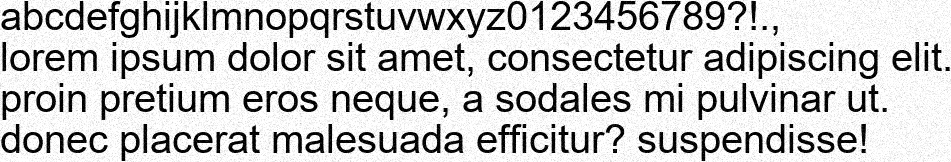

Input text:
abcdefghijklmnopqrstuvwxyz0123456789?!.,
lorem ipsum dolor sit amet, consectetur adipiscing elit.
proin pretium eros neque, a sodales mi pulvinar ut. 
donec placerat malesuada efficitur? suspendisse!

Detected text:

j pq y iiiiiiiiiiiiii
abbcddeefghhhllllljjjkkk!mmmnnnopqrrrstuuuvvvwwwxyyyzzz00011123456789?!!,,iiiiiiiiiiiiiiiiiiiiiii
!oreemmm lllllppsuuummm do!orrr sllllt ammmetiiiiiiiiiiiiiiiiiiiiiiiiii connnsectetuuurrr adlllllpllllsclllllnnng e!lllllt.
prrrolllllnnn prrretllllluuummm errros nnneequuueeiiiiiiiiiiiiiiiiiiiiii a soda!ees mlllll puuu!vvvlllllnnnarrr uuut,,
donneec pp!acerrrat mmma!esuuuada eefflllllcllllltuuurrr? suuspeennndlllllsse!
Confidence: 0.89, Accuracy: 54.06%

j y
abcdefghhijkllllllmnopqrstuvwxyyz011123456789?!,.
lllllorrrem ipsum dolllllorrr sit amet. consectetur adipiscing elllllit.
prrroin prretium erros neque. a sodallllles mi pulllllvinarrr ut,,
donec plllllacerrrat malllllesuada efficiturr? suspendisse!
Confidence: 0.91, Accuracy: 85.84%

abc

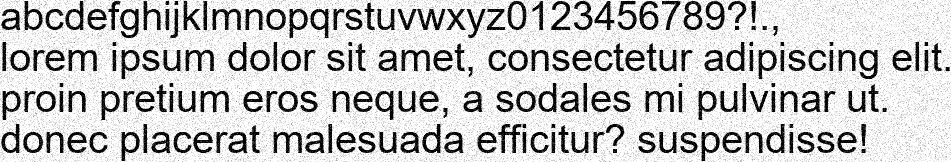

Input text:
abcdefghijklmnopqrstuvwxyz0123456789?!.,
lorem ipsum dolor sit amet, consectetur adipiscing elit.
proin pretium eros neque, a sodales mi pulvinar ut. 
donec placerat malesuada efficitur? suspendisse!

Detected text:

j pq y
abcdefghiiijklllllllmnopqrrrstuvwwwxyyyz011123456789?!,,.
lllllllorrrem iiipsum dolllllllorr siiit amet. consectetur adiiipiiisciiing ellllllliiit.
proiiinn pretiiiumm errros neque. a sodallllllles miii pulllllviiinarrr ut.
donec plllllllacerat malllllllesuuada effiiiciiiturr? suuspendiiisse!
Confidence: 0.89, Accuracy: 78.16%

j y ...
abcdefghijkllllllmnopqrstuvwxyz0123456789?,,...... .
lllllorem ipsum dolllllor sit amet. consectetur adipiscing elllllit.
proin pretium eros neque, a sodallllles mi pulllllvinar ut
donec plllllacerat malllllesuada efficitur? suspendisse!
Confidence: 0.91, Accuracy: 87.39%

abcdefghijkllmnopqrstuvwxyz0123456789?,,,,,, .
lorem ips ..m dolor s ,,,,,,,,.. ,,,,,,,,met consecte,,,,,,,,,,u,,,, adipisc ,,,,,g eli,,,,,,,,,,
p,,,,oi

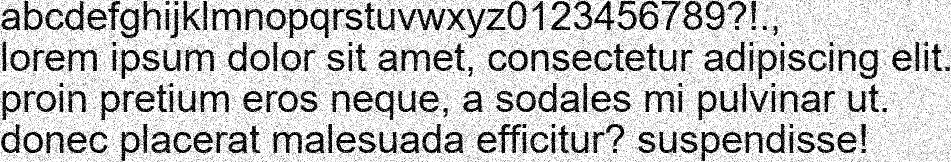

Input text:
abcdefghijklmnopqrstuvwxyz0123456789?!.,
lorem ipsum dolor sit amet, consectetur adipiscing elit.
proin pretium eros neque, a sodales mi pulvinar ut. 
donec placerat malesuada efficitur? suspendisse!

Detected text:

j pq y
abcdefghiiijklllllllmnopqrstuvwxyz0123456789?!.,,
lllllllorem iiipsum dolllllllor siiit amet. consectetur adiiipiiisciiing ellllllliiit
proiiin pretiiium eros neque, a sodallllllles miii pullllllviiinar ut.
donec pllllll..............cerat malllllllesuada effiiiciiitur? suspendiiisse!
Confidence: 0.89, Accuracy: 79.43%

j y
,,,.,,,,bcd,,,,,,, fgr,,,,,,,,,ijklllllmrcpqrs... ,,, w.........yz0123456,,,,,,,,,,,,,9 ,,,,,,,,,,,,
lllllorem iiip ,,,,,,,,,,,,,,,,,,,m dclllll ,,,,,r si.. ,,,,,,,,,,,,r,,,,,,,,,,,,,,,,,t conse,,,,, t,,,,,,,,,,,,,tur adiipis,,, iiin ..c ellllliiit
prciiir,,,,,,,,,, pr,,,, iiiii,,,,,,.,,,m ,,,,,,, ros neq ,,,,,,,,,,,,,,,,,,, a ,,,,odalllll... s miii pulllll. iiin ,,..,,r ,,,,,,,..,,,,,,,,....
dor,,,,,,,,,ec plllll ,,,,,,,,,,,,,,,ceral

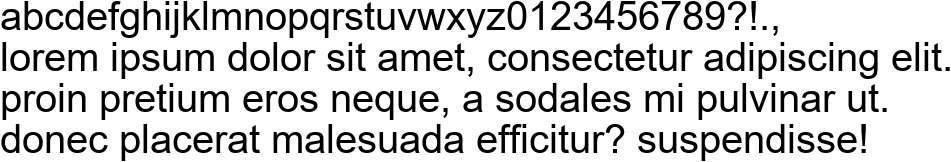

Input text:
abcdefghijklmnopqrstuvwxyz0123456789?!.,
lorem ipsum dolor sit amet, consectetur adipiscing elit.
proin pretium eros neque, a sodales mi pulvinar ut. 
donec placerat malesuada efficitur? suspendisse!

Detected text:

j pq y iiiiiiiiiiiiiiii
aaabbbcdddeeefghhhllllljjjkkk!!mmmnnnopppqqqrssstttuuuvvvwwwxyyyzzz0001112344456789?!!!.iiiiiiiiiiiiiii
!!orreeemmm lllllpppsssuuummm dddo!orrr ssslllllt aaammmeeetttiiiiiiiiiiiii connnssseeecteeetttuuurrr aaadddlllllppplllllsssclllllnnng eee!!lllllt.
ppprrrolllllnnn ppprrreeetttllllluuummm eeerrrosss nnneeeqqquuueeeiiiiiiiiiiiii aaa sssodddaa!eeesss mmm,,,,,,,,,,,,,,,,lllll pppuuu!vvvlllllnnnaaarrr uuut.
dddonnneeec ppp!aaaceeerrraaat mmmaa!eeesssuuuaaadddaaa eeefffflllllclllllttuuurrr? sssuuussspppeeennndddlllllsssssseee!!!
Confidence: 0.89, Accuracy: 46.15%

j y iiiiiiii
abcdefghhhlllljjjkk!mnopqrrrstuuuvvwwwxyyzzz011123456789?!!.iiiiiiiiiiiiii
!orrremmm lllllpsuuumm do!orrr slllt ammmetiiiiiiiiiiiii connnsectetuuurrr adllllplllscllll

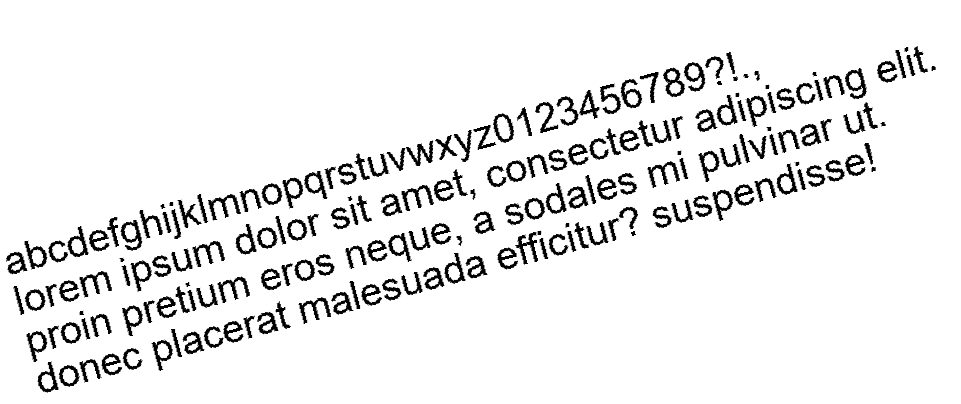

Input text:
abcdefghijklmnopqrstuvwxyz0123456789?!.,
lorem ipsum dolor sit amet, consectetur adipiscing elit.
proin pretium eros neque, a sodales mi pulvinar ut. 
donec placerat malesuada efficitur? suspendisse!

Detected text:

j pq y
abcddefghhhiiijklllllllmnopqrrrstuuvvwwwxyyyz011123456789?!!..
lllllllorrrem iiipsuumm ddolllllllorrr siiit ammet. connsecteturrr adiiipiiisciiinng ee!iiit.
prrroiiinn prrretiiiuumm errros nequue.. a soda!es miii pulllllllvvviiinarrr ut,,,
donnec p!acerrrat ma!esuada effiiiciiiturr? suspenndiiisse!
Confidence: 0.89, Accuracy: 75.25%

j y
abcdefghijklllllmnopqrstuvwwxyyyz0123456789?!,,.
lllllorrrem ipsum dolllllorr sit amet. consecteturr adipiscing elllllit,,
prrroin prretium erros neque. a sodallllles mi pulllllvinar ut,,
donec plllllacerat malllllesuada efficiturr? suspendisse!
Confidence: 0.91, Accuracy: 86.16%

..
abcdefghijklmnopqrstuvwxyz0123456789 ,,,!
lorem ipsum dolor sit amet. consectetur adipiscing elit
proin pretium eros neque. a sodales mi pu

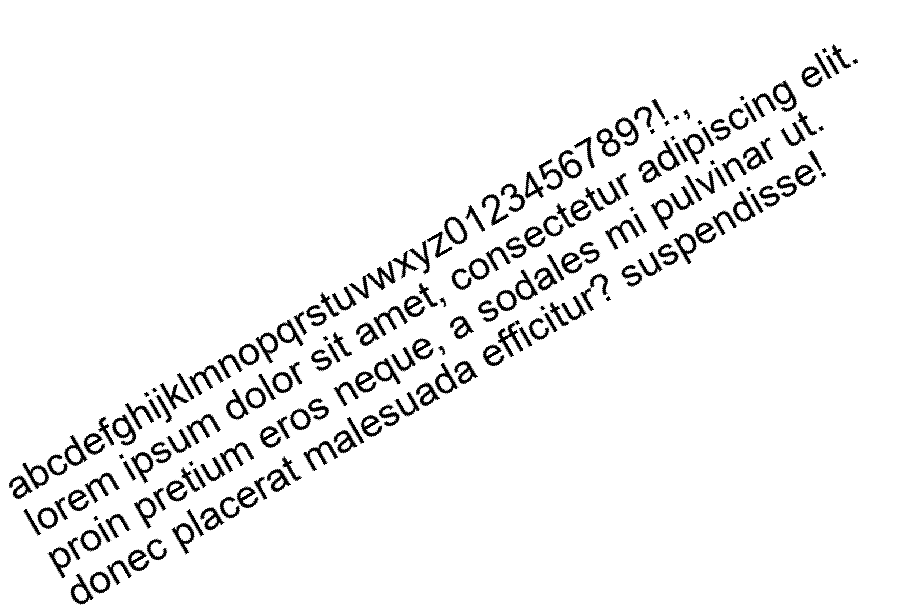

Input text:
abcdefghijklmnopqrstuvwxyz0123456789?!.,
lorem ipsum dolor sit amet, consectetur adipiscing elit.
proin pretium eros neque, a sodales mi pulvinar ut. 
donec placerat malesuada efficitur? suspendisse!

Detected text:

j pq y iiiiiiiiiiiiiiiiii
abbcddefghhhlllljjjkk!mmnnoppqqrrrsttuuuvvvwwwxyyyz0011123456789?!!.iiiiiiiiiiiiiiiiiiiiiiiii
!orrremm lllllppsuummm ddo!orrr slllltt ammmettt,,,,., connnsectttettuuurrr addllllpplllllsclllllnnng e!llllltt.
pprrrolllllnn pprrretllllluuumm errros nnneqquuueiiiiiiiiiiiii a soddaa!es mmmllll ppuuu!vvlllllnnnarr uuutt.
ddonneeec p!acerrraat mmmaa!esuuuaadda efflllllclllltuuurrr? suuussppenndllllssee!!!
Confidence: 0.89, Accuracy: 55.91%

j y ,
abcdefghijklllllmnopqrrstuvwwwxyyyz011123456789?!.,,,,,.
lllllorrem iipsum dolllllorrr sit amet. consecteturrr adipisciing ellllliit.
prroiin prretiuum erros neque,,. a sodallllles mi pulllllviinnarr ut.
donnec plllllacerrrat malllllesuada effiiiciturrr? suuspendiisse!
Confidence: 0.91, Accuracy: 83.

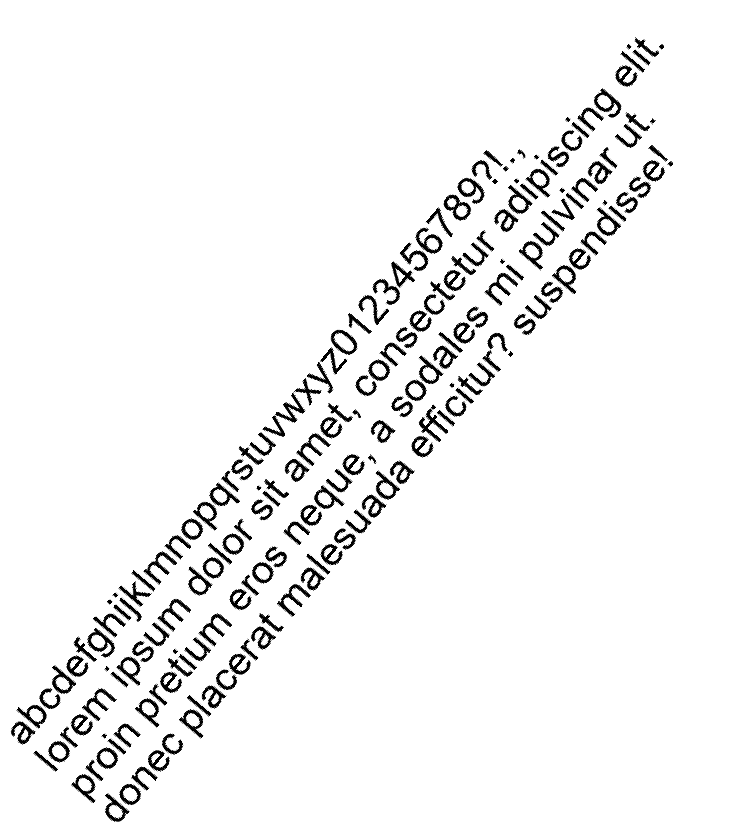

Input text:
abcdefghijklmnopqrstuvwxyz0123456789?!.,
lorem ipsum dolor sit amet, consectetur adipiscing elit.
proin pretium eros neque, a sodales mi pulvinar ut. 
donec placerat malesuada efficitur? suspendisse!

Detected text:

j pq y
aabbcddeffgghhhiijjkklllllllmmnnooppqqrrrsttuuuvvvwwwxyyyzzz000111234456789?!!..
!oorremm iippsuumm ddo!orrr ssiittt ammmeettt. connnseeecttettuurr addiiippiiisciiinngg e!iitt.
pprrrooiinn pprrrettiiiuuumm errrooss nnneqqquuuee. a sodda!ees mmiii ppuuu!vviiinnarrr uutt,,,
ddoonnec pp!acerratt mmmaa!esuuuaaddaa eefffiiiciiituuurrr? ssuuussppennddiissse!!!
Confidence: 0.89, Accuracy: 66.55%

j y
abbcddefghhijjklllllmnopqrrrstuvwxyyz011123456789?!..
lllllorremm ipsuum dollllllorr sit amet. consectetturr addiipiisciinng ellllliitt.
pprrrooiinn pprretiiuum erros nneque. a sodallllles mi ppulllllvviinnarr uut,,
ddonnec pp!acerratt malllllesuada effiiciiturrr? suuspendiisse!
Confidence: 0.91, Accuracy: 80.08%

abcdefghijklllmnopqrstuvwxyz01123456789?!
lllorem i

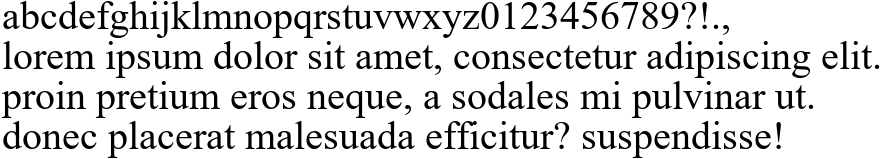

Input text:
abcdefghijklmnopqrstuvwxyz0123456789?!.,
lorem ipsum dolor sit amet, consectetur adipiscing elit.
proin pretium eros neque, a sodales mi pulvinar ut. 
donec placerat malesuada efficitur? suspendisse!

Detected text:

j
abcdefghllljkhnnopqrsuuvwxyz000t23456789?11111,!!!!!!! .
,ttore.m ipsum dottor sittt amettt consecttteu.ur adi .pi!!scmg ehttt,
prompretttium eros neque !a sodates mmputvmaruttt,,
donec pttaceratttmatesuad!!a efficiuur? suspendisse11111
Confidence: 0.89, Accuracy: 75.51%

abcdefghjklmnopqrstuvwxyz0123456789?!..
lorem ipsum dolor sit amet. consectetur adipiscing elit.
proinpretium eros neque. a sodales mipulvinarut.
donec placeratmalesuada efficitur? suspendisse!
Confidence: 0.91, Accuracy: 96.94%

!!!
abcdefghjkimr!!!!opqrstuvwxyz0123456789?ll . ....
.
iorem ipsum doior sit amet. cor!!!!sectetur adipiscir!!!!g e.nt.
proir!!!! pretium eros r!!!!eque. a sodaies. mipuivir!!!!arut.
.
dor!!ec piaceratmaiesuada efficitur ... susper!!dissell
Confidence: 0.93, Accura

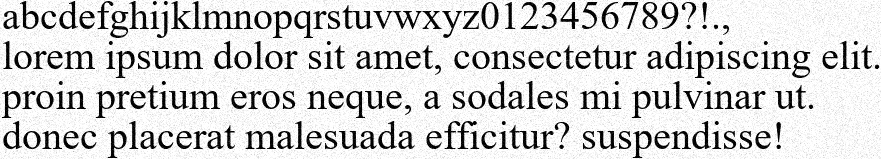

Input text:
abcdefghijklmnopqrstuvwxyz0123456789?!.,
lorem ipsum dolor sit amet, consectetur adipiscing elit.
proin pretium eros neque, a sodales mi pulvinar ut. 
donec placerat malesuada efficitur? suspendisse!

Detected text:

j
abcdefghlllljkhnnopqrsuuuvwxyz0t23456789?11111,!!!!!!! .
,tttore.m ipsum dottor sitt amettt consecteu.ur adi .pi!!scmg ehttt,,,
prompretttium eros nequuue !!a sodates mmmputvmarutt,,,
donec pttaceratmatesuad!!!a efficiuur? suuuspendisse11111
Confidence: 0.89, Accuracy: 74.66%

abcdefghjklmnopqrstuvwxyz011123456789?! .
lorem ipsum dolor sit amet. consectetur adipiscing elit.
proinpretium eros neque. a sodales mipulvinarut.
donec placeratmalesuada effici.................ur? suspendisse!
Confidence: 0.91, Accuracy: 92.20%

!!!! .
abcdefghjkimnopqrstu...wxyz0123456789 ..l .
iorem ipsum doior sillllllll amet. conseclllletur adipiscing eiillllllllll.
proinpretium eros neque. a sodaies. mipuivinarullllllll
.
donec piaceralllllll maiesuada efficillllllllur .. suspend

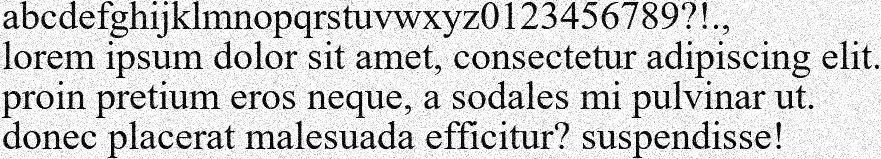

Input text:
abcdefghijklmnopqrstuvwxyz0123456789?!.,
lorem ipsum dolor sit amet, consectetur adipiscing elit.
proin pretium eros neque, a sodales mi pulvinar ut. 
donec placerat malesuada efficitur? suspendisse!

Detected text:

j ......
abcdefghllljk.mmnopqrsn11111vwxyz0t23456789?1111.. ....
.
iiorem ipsuuum dotttor sittt amettt. consecttteuuuur adipiscmg enttt.
prompretttiuum eros nequuue. a sodates mmpuuiivmaruuttt.
donec ptaceratttmaiesuuuada efficiuur!!!!!!!!!! suuuspendisse1111111
Confidence: 0.89, Accuracy: 72.02%

..
abcdefghjklmnopqrstuvwxy......0i2345678....!!!!!! ...1..
lorem ipsum dolor sit ame111111111111. consecte111111111ur adipiscing elit.
proinpretium ero,, neque a sodales mipulvinarut.
donec pl.!!!!cera111111111111 malesuada effici11111111111ur suspendisse1111
Confidence: 0.91, Accuracy: 77.56%

. . ....
b... de...ghjkimnopqr,,....u... ......y. 01 ..45678 ...
iorem ip,unn doi . ,,i... amc... . on,,c ...e.ur dill...i,,cing eii...
proinpr ti m e...o,, neque a ,odaie, nn

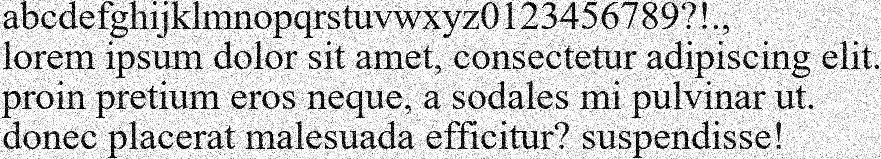

Input text:
abcdefghijklmnopqrstuvwxyz0123456789?!.,
lorem ipsum dolor sit amet, consectetur adipiscing elit.
proin pretium eros neque, a sodales mi pulvinar ut. 
donec placerat malesuada efficitur? suspendisse!

Detected text:

.... !!j
abcdefgn!!!!!!!!jkimnopqr,,tuuu!!! w!!!!!......yz0i23456789 !!!!!!!!111111 ..
torem ipsum dotor ,ittt !!!!lllllllllllllllmet consecteuur adipiscmg eiitt.
prompretttium eros neque.. a ,,odatttes mmmpuivmarut.
donec piacer..lllllllllllllltmaiesuada etttficimr!!!!!!!!!! .......uspendisse1111
Confidence: 0.89, Accuracy: 63.58%

..
ab. d....tgi i kl. n p.11..... ,...u . .....y.. 1123456 ,8 ......... .
lo...em ii s m d. lor ,it ..me.. ... o. ,. ...........et r adii.....i .. ing eli...
proi... p.eti..m ero,, n.......11 .e. a ,,odal...,,, mi i...ui.. in ... .........
.
..111 ..... ec pla......er . mai....s ....ada ..........ii..i...u. .. ,p....... di,s.. .
Confidence: 0.91, Accuracy: 43.10%

.
.ll .l .. l i..lnnn ll .l. ,..u ..v . ,,34....... ,. .... .
lllo...

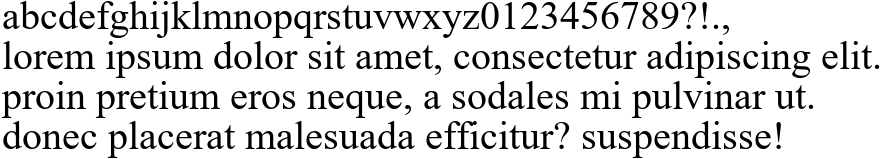

Input text:
abcdefghijklmnopqrstuvwxyz0123456789?!.,
lorem ipsum dolor sit amet, consectetur adipiscing elit.
proin pretium eros neque, a sodales mi pulvinar ut. 
donec placerat malesuada efficitur? suspendisse!

Detected text:

j
abcdefghllljkhnnopqrsuuvwxyz000t23456789?11111,!!!!!!! .
,ttore.m ipsum dottor sittt amettt consecttteu.ur adi .pi!!scmg ehttt,
prompretttium eros neque !a sodates mmputvmaruttt,,
donec pttaceratttmatesuad!!a efficiuur? suspendisse11111
Confidence: 0.89, Accuracy: 75.51%

abcdefghjklmnopqrstuvwxyz0123456789?!..
lorem ipsum dolor sit amet. consectetur adipiscing elit.
proinpretium eros neque. a sodales mipulvinarut.
donec placeratmalesuada efficitur? suspendisse!
Confidence: 0.91, Accuracy: 96.94%

!!!
abcdefghjkimr!!!!opqrstuvwxyz0123456789?ll . ....
.
iorem ipsum doior sit amet. cor!!!!sectetur adipiscir!!!!g e.nt.
proir!!!! pretium eros r!!!!eque. a sodaies. mipuivir!!!!arut.
.
dor!!ec piaceratmaiesuada efficitur ... susper!!dissell
Confidence: 0.93, Accura

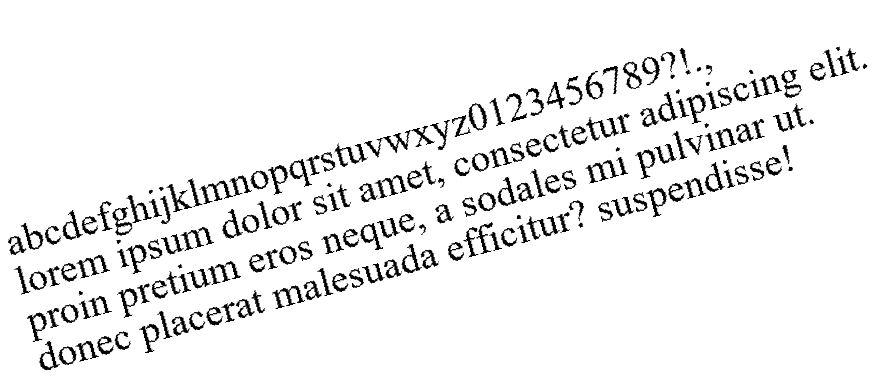

Input text:
abcdefghijklmnopqrstuvwxyz0123456789?!.,
lorem ipsum dolor sit amet, consectetur adipiscing elit.
proin pretium eros neque, a sodales mi pulvinar ut. 
donec placerat malesuada efficitur? suspendisse!

Detected text:

j ......
abcdefghlllljk.mmnopqrsmvwxyz0i23456789 !!!!!!!!!1111 .. .....
.
torem ipsuuum dottor sittt amettt. consecttten1r adipiiscmg e.nttt.
prompretttiiuuum eros nequuue. a sodaiiies mmpuuuiiivmaruuuttt
donec pttaceratttmattesuuuada effiiciimr? suuuspendisse1111
Confidence: 0.89, Accuracy: 70.84%

abcdefghjklmnopqrstuvwxyz011123456789 ,,! .
lorem ipsum dolor sit amet. consectetur adipiscing elit.
proinpretium eros neque a sodales mipulvinarut
donec placeratmalesuada efficitur? suspendisse!
Confidence: 0.91, Accuracy: 94.92%

...
abcdetghjkimnopqrstu...wxy .0!23456 ,,8........
iorem ipsum doior ,i... amc... con,,e.. .......tur adill i,,cing eiit
proinp...etium cros neque a sodaies mi ll, .i. ina.... ......
.
done.. pia. eratmaiesuada etfici..ur .. ,u,,pendi,,s

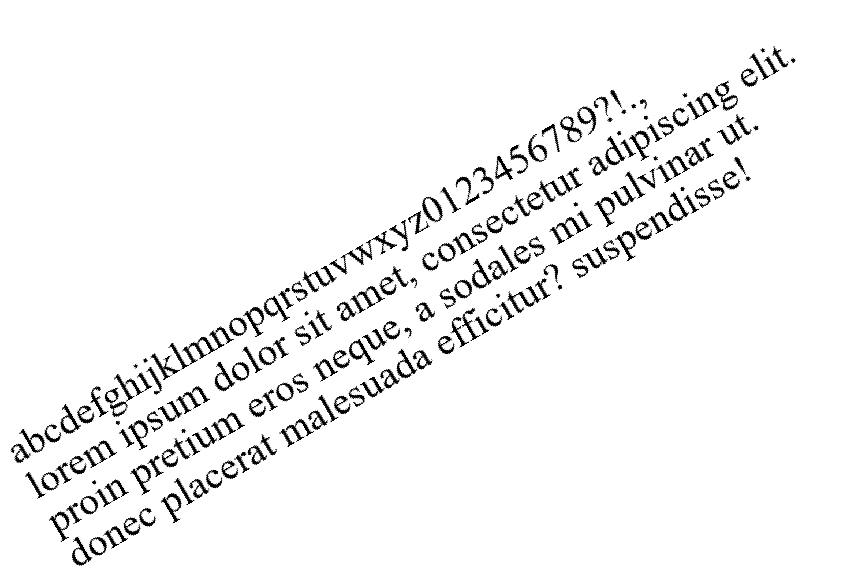

Input text:
abcdefghijklmnopqrstuvwxyz0123456789?!.,
lorem ipsum dolor sit amet, consectetur adipiscing elit.
proin pretium eros neque, a sodales mi pulvinar ut. 
donec placerat malesuada efficitur? suspendisse!

Detected text:

j !!!!!
abcdefghlljkhnnopqrsmvwxyz0i23456789?1111.!!
ttorem iipsuum dotor sitt amettt, consectttemr adipi!!!scmg etittt.
prompretttiuum eros nequuue a sodates mmmpuutvmaruuttt.
!
donec pttaceratttmaiiiesuuuad!!!!a efficin11r? suuuspendisse111111
Confidence: 0.89, Accuracy: 73.42%

abcdefghjklmnopqrstuvwxyz011123456789 ,! .
lorem ipsum dolor sit amet consectetur adipiscing elit
proinpretium eros neque, a sodales mipulvinarut.
donec placeratmalesuada efficitur? su,,pendisse!
Confidence: 0.91, Accuracy: 94.92%

!!! ..
.!!!b..... def!!!!!..hjkimnopqrstu...w..........yz01 ,,345!!!!.. ,,,.9 .l
i.... rem ipsum doior sillllllll amet ... onsectetur adipiscing eiit
proinpretium eros neque a sodaie,, mipuivinarut
don......c piaceratmaiesuada effi... itur .. su,,pendissell

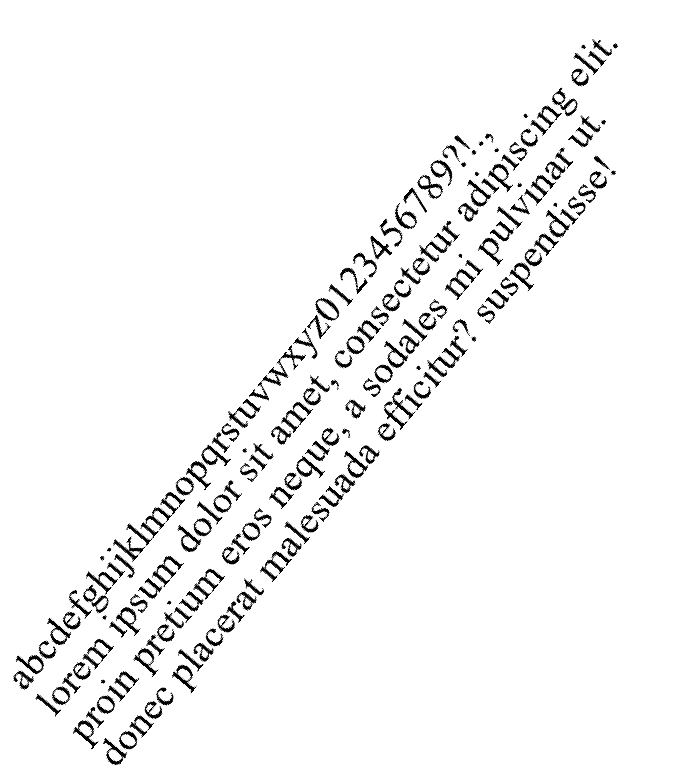

Input text:
abcdefghijklmnopqrstuvwxyz0123456789?!.,
lorem ipsum dolor sit amet, consectetur adipiscing elit.
proin pretium eros neque, a sodales mi pulvinar ut. 
donec placerat malesuada efficitur? suspendisse!

Detected text:

j
abcdefghlljkhnnopqrsuuvwxyz00i23456789 !!!!!!!!!!1111111 ...
iiorem ipsuuum doiiior sit amet, consecttteuur adipiscmg ehtt.
promprettiuum eros nequue.. a sodaiiies mipuuiiivmaruttt.
donec ptaceratttmaiiesuuuada efficin111r? suuspendisse11111111
Confidence: 0.89, Accuracy: 75.51%

..
abcdefghjklmnopqrstuvwxyz011123456789....! .
lorem ipsum dolor ,,it amet. consectetur adipiscing elit.
proinpretium eros neque. a sodales. mipulvinarut
.
donec placeratmalesuada efficitur ... suspendisse!
Confidence: 0.91, Accuracy: 91.63%

.
abcdetghjkimnopqrstuvwxy. 0123456789 ...! .
iorem ipsum doior ,,it amet. ...... on,,ectetur adipiscing eiit.
proinpretium eros neque. a sodaies mi ll,uivinarut
.
donec pia.......eratmaiesuada efti.....itur ... suspendisse!
Confidence: 0.93, A

,font,accuracy
0,arial,61.92
1,times,59.47



Average accuracy by confidence level:


,confidence,accuracy
0,0.89,67.67
1,0.91,79.49
2,0.93,73.73
3,0.95,55.87
4,0.97,26.72



Noise test results (accuracy %):


confidence          0.89   0.91   0.93   0.95   0.97
font  noise_level                                   
arial 0            46.15  61.27  94.69  95.84  87.56
      15           54.06  85.84  96.28  88.94  14.91
      30           78.16  87.39  74.95  13.18   9.65
      50           79.43  38.57  10.21   8.09   7.32
times 0            75.51  96.94  77.27  90.10  63.78
      15           74.66  92.20  76.96  66.50  11.69
      30           72.02  77.56  55.08  17.30   7.46
      50           63.58  43.10  17.71  15.09  10.36


Rotation test results (accuracy %):


confidence             0.89   0.91   0.93   0.95   0.97
font  rotation_angle                                   
arial 0               46.15  61.27  94.69  95.84  87.56
      15              75.25  86.16  95.50  39.56  11.31
      30              55.91  83.12  96.08  75.40   6.41
      50              66.55  80.08  94.17  79.73  13.68
times 0               75.51  96.94  77.27  90.10  63.78
      15              70.84  94.92  67.58  19.83  11.51
      30              73.42  94.92  70.46  47.19  13.14
      50              75.51  91.63  80.85  51.16   7.32

In [4]:
os.makedirs(IMG_DIR, exist_ok=True)

font_size = 40
fonts = ["arial", "times"]
conf_levels = [0.89, 0.91, 0.93, 0.95, 0.97]
noise_levels = [0, 15, 30, 50]
rotation_angles = [0, 15, 30, 50]

text = """abcdefghijklmnopqrstuvwxyz0123456789?!.,
lorem ipsum dolor sit amet, consectetur adipiscing elit.
proin pretium eros neque, a sodales mi pulvinar ut. 
donec placerat malesuada efficitur? suspendisse!"""

results = []
print_char_counts = True

for font in fonts:
    print(f"\nNOISE TEST - {font}")
    print("=" * 40 + "\n")

    for noise in noise_levels:
        create_text_image(text, font, font_size, noise)
        image = load_image(
            os.path.join(IMG_DIR, f"sample-{font}-{noise}-0.png"),
            invert=False,
        )
        print(f"Font: {font}, noise: {noise}\n")
        display(image)
        print(f"Input text:\n{text}\n")
        print("Detected text:\n")

        for conf in conf_levels:
            detected_text, character_counts = ocr(image, font, font_size, conf)
            accuracy = (
                SequenceMatcher(None, detected_text.strip(), text.strip()).ratio()
                * 100
            )

            results.append(
                {
                    "font": font,
                    "test_type": "noise",
                    "noise_level": noise,
                    "rotation_angle": 0,
                    "confidence": conf,
                    "accuracy": round(accuracy, 2),
                }
            )

            print(detected_text.strip())
            print(f"Confidence: {conf}, Accuracy: {accuracy:.2f}%\n")
            if print_char_counts:
                print_char_counts = False
                print("Character counts (only for the first image, for display purposes):")
                for char, count in character_counts.items():
                    print(f"{char}: {count}")
                print()
        print("-" * 40 + "\n")

    print(f"\n\nROTATION TEST - {font}")
    print("=" * 40 + "\n")

    for rotation in rotation_angles:
        create_text_image(
            text, font, font_size, noise_level=0, rotation_angle=rotation
        )
        image = load_image(
            os.path.join(IMG_DIR, f"sample-{font}-0-{rotation}.png"),
            invert=False,
        )
        print(f"Font: {font}, rotation: {rotation}\n")
        display(image)
        print(f"Input text:\n{text}\n")
        print("Detected text:\n")

        for conf in conf_levels:
            detected_text, character_counts = ocr(image, font, font_size, conf)
            accuracy = (
                SequenceMatcher(None, detected_text.strip(), text.strip()).ratio()
                * 100
            )

            results.append(
                {
                    "font": font,
                    "test_type": "rotation",
                    "noise_level": 0,
                    "rotation_angle": rotation,
                    "confidence": conf,
                    "accuracy": round(accuracy, 2),
                }
            )

            print(detected_text.strip())
            print(f"Confidence: {conf}, Accuracy: {accuracy:.2f}%\n")
        print("-" * 40 + "\n")

display_results(results)

### 5. Wnioski z przeprowadzonych testów

#### 5.1 Wpływ poziomu szumu na dokładność OCR

- **Brak szumu**: Najwyższa dokładność rozpoznawania dla obu czcionek, osiągająca prawie perfekcyjne wyniki
- **Niskie natężenie (~15)**: Niewielki spadek dokładności
- **Średnie natężenie (~30)**: Znaczny spadek dokładności, szczególnie widoczny przy zbyt wysokich progach pewności
- **Wysokie natężenie (~50)**: Drastyczne pogorszenie jakości rozpoznawania, często poniżej 50% dokładności

#### 5.2 Wpływ rotacji na dokładność OCR

- **Rotacja 0°**: Optymalne warunki, najwyższa dokładność
- **Rotacja 15°**: Minimalny spadek dokładności
- **Rotacja 30°**: Dokładność zbliżona do 15°
- **Rotacja 50°**: Umiarkowany spadek dokładności, ale algorytm korekcji rotacji radzi sobie stosunkowo dobrze

#### 5.3 Porównanie czcionek

- **Arial (bezszeryfowa)**: Generalnie lepsza rozpoznawalność ze względu na prostszą strukturę znaków, bardziej odporna na degradację jakości obrazu
- **Times (szeryfowa)**: Nieco gorsza dokładność, szczególnie przy obecności szumu, ze względu na dodatkowe elementy dekoracyjne

#### 5.4 Wpływ progu pewności (confidence threshold)

- **Niskie progi (0.89-0.91)**: Więcej fałszywie pozytywnych rozpoznań, ale również więcej wykrytych znaków
- **Wysokie progi (0.93-0.95)**: Z reguły najlepsze wyniki
- **Wysokie progi (0.97)**: Duże ryzyko pominięcia poprawnych znaków, nieskuteczne dla zniekształconego tekstu
- **Optymalny próg**: Zazwyczaj w zakresie 0.93-0.95, zapewniający najlepszy kompromis - zależny od rodzaju i intensywności zniekształceń tekstu na obrazie

#### 5.5 Skuteczność zastosowanych metod

- **Korelacja wzajemna z FFT**: Skuteczna metoda dopasowywania wzorców, umożliwiająca szybkie wyszukiwanie znaków
- **Odszumianie**: Kluczowy krok preprocesingu, znacząco poprawiający wyniki dla zaszumionych obrazów
- **Korekcja rotacji**: Skuteczna dla niewielkich odchyleń (do 30°)